In [2]:
%matplotlib inline
import mxnet as mx
from mxnet import gluon
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import json
import os
from itertools import islice
from pathlib import Path

In [3]:
mx.random.seed(0)
np.random.seed(0)

## Datasets

In [ ]:
'''
GluonTS提供了三种方法来定义数据集
    1、使用由GluonTS提供的可用数据集(已具备GluonTS模式，不需要再处理)
    2、使用GluonTS创建一个人工数据集
    3、以GluonTS模式定义自己的数据集
至少应满足的GluonTS模式：
    1、数据项/data entries(时间序列)的可迭代集合
    2、每一项是一个字典，至少包含target字段(包含时间序列的值)、start字段(指明时间序列的开始日期)
'''

### Available datasets in GluonTS

In [4]:
from gluonts.dataset.repository.datasets import get_dataset, dataset_recipes
from gluonts.dataset.util import to_pandas

In [5]:
print(f"Available datasets: {list(dataset_recipes.keys())}")

Available datasets: ['constant', 'exchange_rate', 'solar-energy', 'electricity', 'traffic', 'exchange_rate_nips', 'electricity_nips', 'traffic_nips', 'solar_nips', 'wiki-rolling_nips', 'taxi_30min', 'm4_hourly', 'm4_daily', 'm4_weekly', 'm4_monthly', 'm4_quarterly', 'm4_yearly', 'm5']


In [7]:
dataset = get_dataset("m4_hourly", regenerate=False) # 如果已经下载好数据集，则将参数regenerate设为False

In [ ]:
'''
由GluonTS提供的数据集包含三个部分
    1、dataset.train：用于训练的数据项可迭代集合
    2、dataset.test：用于推断的数据项可迭代集合，测试集是训练集的一个扩充版本，即在每个时间序列的末尾包含一个训练中不可见的窗口，窗口的长度等于预测长度
    3、dataset.metadata：比如时间序列的频率、预测长度、相应的特征等
'''

In [8]:
# get the first time series in the training set
train_entry = next(iter(dataset.train))
train_entry.keys()

dict_keys(['start', 'target', 'feat_static_cat', 'item_id', 'source'])

In [9]:
# get the first time series in the test set
test_entry = next(iter(dataset.test))
test_entry.keys()

dict_keys(['start', 'target', 'feat_static_cat', 'item_id', 'source'])

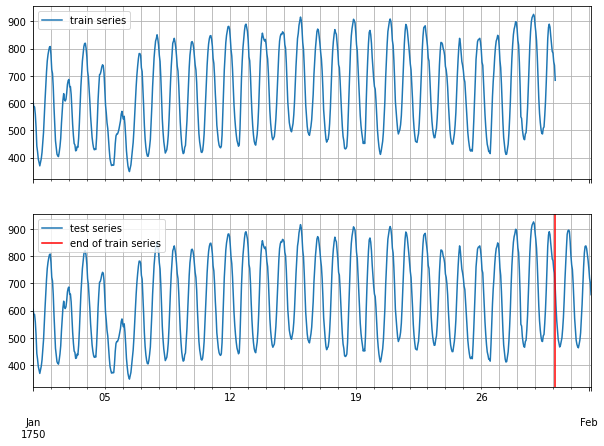

In [10]:
# 取时间以及对应的目标值
test_series = to_pandas(test_entry)
train_series = to_pandas(train_entry)

fig, ax = plt.subplots(2, 1, sharex=True, sharey=True, figsize=(10, 7))

train_series.plot(ax=ax[0])
ax[0].grid(which="both")
ax[0].legend(["train series"], loc="upper left")

test_series.plot(ax=ax[1])
ax[1].axvline(train_series.index[-1], color='r') # end of train dataset
ax[1].grid(which="both")
ax[1].legend(["test series", "end of train series"], loc="upper left")

plt.show()

In [11]:
print(f"Length of forecasting window in test dataset: {len(test_series) - len(train_series)}")
print(f"Recommended prediction horizon: {dataset.metadata.prediction_length}")
print(f"Frequency of the time series: {dataset.metadata.freq}")

Length of forecasting window in test dataset: 48
Recommended prediction horizon: 48
Frequency of the time series: H


### Create artificial datasets

In [12]:
# 使用ComplexSeasonalTimeSeries模块
from gluonts.dataset.artificial import ComplexSeasonalTimeSeries
from gluonts.dataset.common import ListDataset

In [13]:
artificial_dataset = ComplexSeasonalTimeSeries(
    num_series=10,
    prediction_length=21,
    freq_str="H",
    length_low=30,
    length_high=200,
    min_val=-10000,
    max_val=10000,
    is_integer=False,
    proportion_missing_values=0,
    is_noise=True,
    is_scale=True,
    percentage_unique_timestamps=1,
    is_out_of_bounds_date=True,
)

In [14]:
print(f"prediction length: {artificial_dataset.metadata.prediction_length}")
print(f"frequency: {artificial_dataset.metadata.freq}")

prediction length: 21
frequency: H


In [15]:
# 创建的人工数据集是一个字典的列表
print(f"type of train dataset: {type(artificial_dataset.train)}")
print(f"train dataset fields: {artificial_dataset.train[0].keys()}")
print(f"type of test dataset: {type(artificial_dataset.test)}")
print(f"test dataset fields: {artificial_dataset.test[0].keys()}")

type of train dataset: <class 'list'>
train dataset fields: dict_keys(['start', 'target', 'item_id'])
type of test dataset: <class 'list'>
test dataset fields: dict_keys(['start', 'target', 'item_id'])


In [16]:
train_ds = ListDataset(
    artificial_dataset.train,
    freq=artificial_dataset.metadata.freq
)

In [17]:
test_ds = ListDataset(
    artificial_dataset.test,
    freq=artificial_dataset.metadata.freq
)

In [18]:
train_entry = next(iter(train_ds))
train_entry.keys()

dict_keys(['start', 'target', 'item_id', 'source'])

In [19]:
test_entry = next(iter(test_ds))
test_entry.keys()

dict_keys(['start', 'target', 'item_id', 'source'])

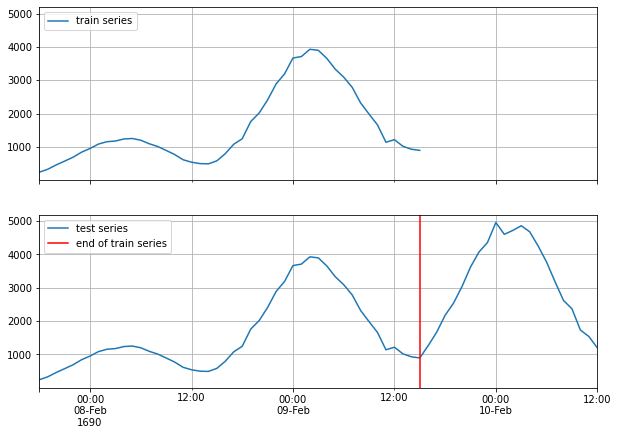

In [20]:
test_series = to_pandas(test_entry)
train_series = to_pandas(train_entry)

fig, ax = plt.subplots(2, 1, sharex=True, sharey=True, figsize=(10, 7))

train_series.plot(ax=ax[0])
ax[0].grid(which="both")
ax[0].legend(["train series"], loc="upper left")

test_series.plot(ax=ax[1])
ax[1].axvline(train_series.index[-1], color='r') # end of train dataset
ax[1].grid(which="both")
ax[1].legend(["test series", "end of train series"], loc="upper left")

plt.show()

### Use your time series and features

In [ ]:
'''
所有可用的字段可分为以下三类
    1、必需的
        start：时间序列的开始日期
        target：时间序列值
    2、可选的
        feat_static_cat：静态类特征，一个维数等于特征数的列表
        feat_static_real：静态实值特征，一个维数等于特征数的列表
        feat_dynamic_cat：动态类特征，形如(number of features, target length)的数组
        feat_dynamic_real：动态实值特征，形如(number of features, target length)的数组
    3、由Transformation添加的
        time_feat：与时间(月/日)相关的特征
        feat_dynamic_const：沿时间轴展开定值特征
        feat_dynamic_age：年龄特征，该特征的值对于遥远的过去时间戳来说很小，并且随着我们接近当前时间戳，它单调地增加
        observed_values：可观测值的指示器，如果值被观测到为1，否则为0
        is_pad：每个时间步的指示器，显示是否padded(在长度不够时)
        forecast_start：预测开始日期
'''

In [21]:
from gluonts.dataset.field_names import FieldName

In [22]:
[f"FieldName.{k} = '{v}'" for k, v in FieldName.__dict__.items() if not k.startswith('_')]

["FieldName.ITEM_ID = 'item_id'",
 "FieldName.START = 'start'",
 "FieldName.TARGET = 'target'",
 "FieldName.FEAT_STATIC_CAT = 'feat_static_cat'",
 "FieldName.FEAT_STATIC_REAL = 'feat_static_real'",
 "FieldName.FEAT_DYNAMIC_CAT = 'feat_dynamic_cat'",
 "FieldName.FEAT_DYNAMIC_REAL = 'feat_dynamic_real'",
 "FieldName.PAST_FEAT_DYNAMIC_REAL = 'past_feat_dynamic_real'",
 "FieldName.FEAT_DYNAMIC_REAL_LEGACY = 'dynamic_feat'",
 "FieldName.FEAT_DYNAMIC = 'feat_dynamic'",
 "FieldName.PAST_FEAT_DYNAMIC = 'past_feat_dynamic'",
 "FieldName.FEAT_TIME = 'time_feat'",
 "FieldName.FEAT_CONST = 'feat_dynamic_const'",
 "FieldName.FEAT_AGE = 'feat_dynamic_age'",
 "FieldName.OBSERVED_VALUES = 'observed_values'",
 "FieldName.IS_PAD = 'is_pad'",
 "FieldName.FORECAST_START = 'forecast_start'",
 "FieldName.TARGET_DIM_INDICATOR = 'target_dimension_indicator'"]

In [23]:
# 创建一个简单的数据集，包含一个target、一个实值动态特征(设置为一个周期前的目标值)和一个静态类特征(指明用于创建目标值的sinusoid类型/不同相)
# target: (num_series, num_steps)   target = noise + pattern
# feat_dynamic_real: (num_series, num_steps) 
# feat_static_cat: (num_series,)
def create_dataset(num_series, num_steps, period=24, mu=1, sigma=0.3):
    # create target: noise + pattern
    # noise
    noise = np.random.normal(mu, sigma, size=(num_series, num_steps))

    # pattern - sinusoid with different phase
    sin_minusPi_Pi = np.sin(np.tile(np.linspace(-np.pi, np.pi, period), int(num_steps / period)))
    sin_Zero_2Pi = np.sin(np.tile(np.linspace(0, 2 * np.pi, 24), int(num_steps / period)))

    pattern = np.concatenate(
        (
            np.tile(
                sin_minusPi_Pi.reshape(1, -1),
                (int(np.ceil(num_series / 2)),1)
            ),
            np.tile(
                sin_Zero_2Pi.reshape(1, -1),
                (int(np.floor(num_series / 2)), 1)
            )
        ),
        axis=0
    )

    target = noise + pattern

    # create time features: use target one period earlier, append with zeros
    feat_dynamic_real = np.concatenate(
        (
            np.zeros((num_series, period)),
            target[:, :-period]
        ),
        axis=1
    )

    # create categorical static feats: use the sinusoid type as a categorical feature
    feat_static_cat = np.concatenate(
        (
            np.zeros(int(np.ceil(num_series / 2))),
            np.ones(int(np.floor(num_series / 2)))
        ),
        axis=0
    )

    return target, feat_dynamic_real, feat_static_cat

In [24]:
# define the parameters of the dataset
custom_ds_metadata = {
    'num_series': 100,
    'num_steps': 24 * 7,
    'prediction_length': 24,
    'freq': '1H',
    'start': [
        pd.Timestamp("01-01-2019", freq='1H')
        for _ in range(100)
    ]
}

In [25]:
data_out = create_dataset(
    custom_ds_metadata['num_series'],
    custom_ds_metadata['num_steps'],
    custom_ds_metadata['prediction_length']
)

target, feat_dynamic_real, feat_static_cat = data_out
print(target.shape, feat_dynamic_real.shape, feat_static_cat.shape)

(100, 168) (100, 168) (100,)


In [26]:
# 创建训练集时需要截去最后一个窗口
train_ds = ListDataset(
    [
        {
            FieldName.TARGET: target,
            FieldName.START: start,
            FieldName.FEAT_DYNAMIC_REAL: [fdr],
            FieldName.FEAT_STATIC_CAT: [fsc]
        }
        for (target, start, fdr, fsc) in zip(
            target[:, :-custom_ds_metadata['prediction_length']],
            custom_ds_metadata['start'],
            feat_dynamic_real[:, :-custom_ds_metadata['prediction_length']],
            feat_static_cat
        )
    ],
    freq=custom_ds_metadata['freq']
)

In [27]:
test_ds = ListDataset(
    [
        {
            FieldName.TARGET: target,
            FieldName.START: start,
            FieldName.FEAT_DYNAMIC_REAL: [fdr],
            FieldName.FEAT_STATIC_CAT: [fsc]
        }
        for (target, start, fdr, fsc) in zip(
            target,
            custom_ds_metadata['start'],
            feat_dynamic_real,
            feat_static_cat)
    ],
    freq=custom_ds_metadata['freq']
)

In [28]:
train_entry = next(iter(train_ds))
train_entry.keys()

dict_keys(['target', 'start', 'feat_dynamic_real', 'feat_static_cat', 'source'])

In [29]:
test_entry = next(iter(test_ds))
test_entry.keys()

dict_keys(['target', 'start', 'feat_dynamic_real', 'feat_static_cat', 'source'])

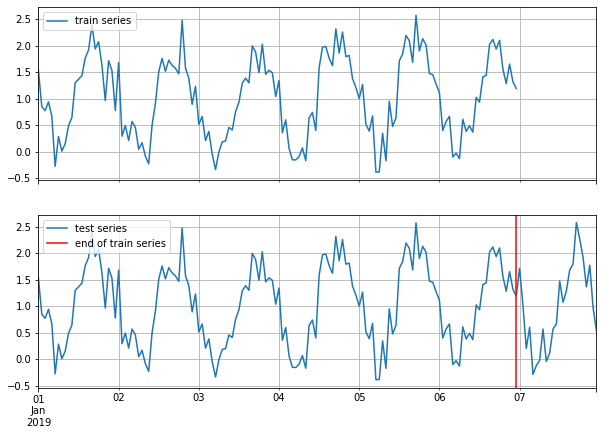

In [30]:
test_series = to_pandas(test_entry)
train_series = to_pandas(train_entry)

fig, ax = plt.subplots(2, 1, sharex=True, sharey=True, figsize=(10, 7))

train_series.plot(ax=ax[0])
ax[0].grid(which="both")
ax[0].legend(["train series"], loc="upper left")

test_series.plot(ax=ax[1])
ax[1].axvline(train_series.index[-1], color='r') # end of train dataset
ax[1].grid(which="both")
ax[1].legend(["test series", "end of train series"], loc="upper left")

plt.show()

## Transformations

In [ ]:
'''
Transformation的主要用于特征处理，例如，添加holiday特征，以及定义在训练和推断期间将数据集拆分为适当窗口的方式
一般来说，它获取一个数据集项的可迭代集合，并将其转换为另一个可迭代集合，该集合可能包含更多字段。transformation是通过定义一组对原始数据集的“操作”来完成的，这取决于对我们的模型有用的内容。这些操作通常创建一些附加特征或转换现有特征。例如，在下面的示例中，我们添加了以下转换：
    AddObservedValuesIndicator: 创建字段observed_values
    AddAgeFeature: 创建字段feat_dynamic_age
可以使用的另一个transformation是InstanceSplitter，它用于定义在训练、验证或预测时如何在示例窗口中拆分数据集。InstanceSplitter的配置如下：
    is_pad_field: 时间序列是否padded的指示器(长度不够)
    train_sampler：定义训练窗口如何被切断/采样
    time_series_fields：包含需要以与目标相同的方式拆分的时间依赖特征
'''

In [31]:
from gluonts.transform import (
    AddAgeFeature,
    AddObservedValuesIndicator,
    Chain,
    ExpectedNumInstanceSampler,
    InstanceSplitter,
    SetFieldIfNotPresent,
)

In [37]:
def create_transformation(freq, context_length, prediction_length):
    return Chain(
        [
            AddObservedValuesIndicator(
                target_field=FieldName.TARGET,
                output_field=FieldName.OBSERVED_VALUES,
            ),
            AddAgeFeature(
                target_field=FieldName.TARGET,
                output_field=FieldName.FEAT_AGE,
                pred_length=prediction_length,
                log_scale=True,
            ),
            InstanceSplitter(
                target_field=FieldName.TARGET,
                is_pad_field=FieldName.IS_PAD,
                start_field=FieldName.START,
                forecast_start_field=FieldName.FORECAST_START,
                train_sampler=ExpectedNumInstanceSampler(num_instances=1),
                past_length=context_length,
                future_length=prediction_length,
                time_series_fields=[
                    FieldName.FEAT_AGE,
                    FieldName.FEAT_DYNAMIC_REAL,
                    FieldName.OBSERVED_VALUES,
                ],
            ),
        ]
    )

In [38]:
transformation = create_transformation(
    custom_ds_metadata['freq'],
    2 * custom_ds_metadata['prediction_length'], # can be any appropriate value
    custom_ds_metadata['prediction_length']
)

In [39]:
train_tf = transformation(iter(train_ds), is_train=True) # 当is_train=True，InstanceSplitter在转换后的数据集上迭代，并通过随机选择一个时间序列和该时间序列上的起点来切割窗口(这种“随机性”由train_sampler定义)

In [40]:
type(train_tf)

generator

In [41]:
train_tf_entry = next(iter(train_tf))
[k for k in train_tf_entry.keys()]

['start',
 'feat_static_cat',
 'source',
 'past_feat_dynamic_age',
 'future_feat_dynamic_age',
 'past_feat_dynamic_real',
 'future_feat_dynamic_real',
 'past_observed_values',
 'future_observed_values',
 'past_target',
 'future_target',
 'past_is_pad',
 'forecast_start']

In [ ]:
'''
将窗口分为过去和未来，并为所有与时间相关的字段添加了相应的前缀。这样，我们可以很容易地使用如，past_target字段作为输入和future_target字段来计算我们的预测误差。过去的长度等于上下文的长度，未来的长度等于预测的长度
'''

In [42]:
print(f"past target shape: {train_tf_entry['past_target'].shape}")
print(f"future target shape: {train_tf_entry['future_target'].shape}")
print(f"past observed values shape: {train_tf_entry['past_observed_values'].shape}")
print(f"future observed values shape: {train_tf_entry['future_observed_values'].shape}")
print(f"past age feature shape: {train_tf_entry['past_feat_dynamic_age'].shape}")
print(f"future age feature shape: {train_tf_entry['future_feat_dynamic_age'].shape}")
print(train_tf_entry['feat_static_cat'])

past target shape: (48,)
future target shape: (24,)
past observed values shape: (48,)
future observed values shape: (24,)
past age feature shape: (48, 1)
future age feature shape: (24, 1)
[0]


In [43]:
print(f"past_feat_dynamic_real shape: {train_tf_entry['past_feat_dynamic_real'].shape}")
print(f"future_feat_dynamic_real shape: {train_tf_entry['future_feat_dynamic_real'].shape}")
print(train_tf_entry['feat_static_cat'].shape)

past_feat_dynamic_real shape: (48, 1)
future_feat_dynamic_real shape: (24, 1)
(1,)


In [44]:
[k for k in next(iter(train_ds)).keys()]

['target', 'start', 'feat_dynamic_real', 'feat_static_cat', 'source']

In [ ]:
'''
在推断过程中(is_train=False)，拆分器总是剪切数据集的最后一个窗口(长度为上下文长度)，因此它可以用来预测长度为预测长度的后续未知值
'''

In [45]:
test_tf = transformation(iter(test_ds), is_train=False)

In [46]:
test_tf_entry = next(iter(test_tf))
[k for k in test_tf_entry.keys()]

['start',
 'feat_static_cat',
 'source',
 'past_feat_dynamic_age',
 'future_feat_dynamic_age',
 'past_feat_dynamic_real',
 'future_feat_dynamic_real',
 'past_observed_values',
 'future_observed_values',
 'past_target',
 'future_target',
 'past_is_pad',
 'forecast_start']

In [47]:
print(f"past target shape: {test_tf_entry['past_target'].shape}")
print(f"future target shape: {test_tf_entry['future_target'].shape}")
print(f"past observed values shape: {test_tf_entry['past_observed_values'].shape}")
print(f"future observed values shape: {test_tf_entry['future_observed_values'].shape}")
print(f"past age feature shape: {test_tf_entry['past_feat_dynamic_age'].shape}")
print(f"future age feature shape: {test_tf_entry['future_feat_dynamic_age'].shape}")
print(test_tf_entry['feat_static_cat'])

past target shape: (48,)
future target shape: (0,)
past observed values shape: (48,)
future observed values shape: (0,)
past age feature shape: (48, 1)
future age feature shape: (24, 1)
[0]


In [48]:
print(f"past_feat_dynamic_real shape: {test_tf_entry['past_feat_dynamic_real'].shape}")
print(f"future_feat_dynamic_real shape: {test_tf_entry['future_feat_dynamic_real'].shape}")

past_feat_dynamic_real shape: (48, 1)
future_feat_dynamic_real shape: (0, 1)


## Training an existing model

In [ ]:
'''
GluonTS附带了许多预构建的模型，用户只需配置一些超参数。现有的模型侧重于(但不限于)概率预测。概率预测是以概率分布的形式进行的预测，而不是简单的点估计。在预测范围中估计每个时间步的未来分布之后，我们可以从每个时间步的分布中提取一个样本，从而创建一个可以被视为未来可能实现的“样本路径”。在实践中，我们绘制多个样本并创建多个样本路径，这些样本路径可用于可视化、模型评估、导出统计数据等
'''

### Configuring an estimator

In [ ]:
'''
将从GulonTS预先构建的前馈神经网络估计器开始，这是一个简单但功能强大的预测模型。我们将使用此模型演示训练模型、生成预测和评估结果的过程。GluonTS的内置前馈神经网络(SimpleFeedForwardEstimator)接受长度为上下文长度的输入窗口，并预测后续长度为预测长度的值的分布。前馈神经网络模型就是Estimator的一个例子。在GluonTS中，Estimator对象表示一个预测模型及其系数、权重等细节。一般来说，每个estimator(预构建或定制)由多个超参数配置，这些超参数可以是所有估计器中的公共参数(但不具有约束力binding)(例如，预测长度)或特定估计器的特定参数(例如，神经网络的层数或CNN中的步长stride)。最后，每个估计器由Trainer配置，它定义了如何训练模型，即epochs数、学习率等
'''

In [49]:
from gluonts.model.simple_feedforward import SimpleFeedForwardEstimator
from gluonts.trainer import Trainer

/home/yaoqf/miniconda3/envs/gluonts/lib/python3.6/site-packages/ipykernel_launcher.py:2: DeprecationWarning: gluonts.trainer is deprecated. Use gluonts.mx.trainer instead.
  


In [50]:
estimator = SimpleFeedForwardEstimator(
    num_hidden_dimensions=[10],
    prediction_length=custom_ds_metadata['prediction_length'],
    context_length=2*custom_ds_metadata['prediction_length'],
    freq=custom_ds_metadata['freq'],
    trainer=Trainer(ctx="cpu",
                    epochs=5,
                    learning_rate=1e-3,
                    hybridize=False,
                    num_batches_per_epoch=100
                   )
)

### Getting a predictor

In [ ]:
'''
在使用所有必要的超参数指定估计器之后，我们可以使用训练数据集来训练它(通过调用估计器的训练方法)。训练算法返回可用于构建预测的拟合模型(GluonTS术语中的Predictor)。在这里我们应该强调的是，一个单一的模型，如上面定义的，是在训练数据集train_ds中包含的所有时间序列上训练的。这就产生了一个全局模型，适用于train_ds中所有时间序列的预测，也可能适用于其他看不见的相关时间序列
'''

In [51]:
predictor = estimator.train(train_ds)

100%|██████████| 100/100 [00:01<00:00, 83.25it/s, epoch=5/5, avg_epoch_loss=0.623]


### Saving/Loading an existing model

In [52]:
# save the trained model in tmp/
from pathlib import Path
predictor.serialize(Path("/tmp/"))

In [53]:
# loads it back
from gluonts.model.predictor import Predictor
predictor_deserialized = Predictor.deserialize(Path("/tmp/"))

## Evaluation

### Getting the forecasts

In [ ]:
'''
有了预测器，我们现在可以预测dataset.test的最后一个窗口并评估模型的性能。GluonTS附带make_evaluation_predictions函数，该函数自动执行预测和模型评估过程。大致来说，此函数执行以下步骤：
    1、移除dataset.test的长度为prediction_length的最后一个窗口(我们想要预测)
    2、估计器使用剩余的数据来预测(以样本路径的形式)刚刚移除的“未来”窗口
    3、该模块输出预测样本路径和dataset.test 
'''

In [54]:
from gluonts.evaluation.backtest import make_evaluation_predictions

In [55]:
forecast_it, ts_it = make_evaluation_predictions(
    dataset=test_ds,  # test dataset
    predictor=predictor,  # predictor
    num_samples=100,  # number of sample paths we want for evaluation
)

In [56]:
forecasts = list(forecast_it)
tss = list(ts_it)

In [57]:
# first entry of the time series list
ts_entry = tss[0]

In [59]:
# first 5 values of the time series (convert from pandas to numpy)
np.array(ts_entry[:5]).reshape(-1,)

array([1.5292157 , 0.85025036, 0.7740374 , 0.941432  , 0.6723822 ],
      dtype=float32)

In [60]:
# first entry of test_ds
test_ds_entry = next(iter(test_ds))

In [61]:
# first 5 values
test_ds_entry['target'][:5]

array([1.5292157 , 0.85025036, 0.7740374 , 0.941432  , 0.6723822 ],
      dtype=float32)

In [62]:
# first entry of the forecast list
forecast_entry = forecasts[0]

In [63]:
print(f"Number of sample paths: {forecast_entry.num_samples}")
print(f"Dimension of samples: {forecast_entry.samples.shape}")
print(f"Start date of the forecast window: {forecast_entry.start_date}")
print(f"Frequency of the time series: {forecast_entry.freq}")

Number of sample paths: 100
Dimension of samples: (100, 24)
Start date of the forecast window: 2019-01-07 00:00:00
Frequency of the time series: 1H


In [ ]:
'''
总结样本路径，例如计算预测窗口中24个时间步中每个时间步的平均值或分位数quantile
'''

In [64]:
print(f"Mean of the future window:\n {forecast_entry.mean}")
print(f"0.5-quantile (median) of the future window:\n {forecast_entry.quantile(0.5)}")

Mean of the future window:
 [ 0.8605477   0.615948    0.5159973   0.44300067  0.24408723 -0.0639623
  0.0753729   0.37274846  0.22590446  0.34221733  0.63699657  0.76362
  1.2630337   1.493244    1.635315    1.850508    1.7365319   1.8068124
  1.9704095   1.8011849   1.7296801   1.530947    1.2304059   1.105966  ]
0.5-quantile (median) of the future window:
 [ 0.873091    0.64431304  0.47843176  0.40411055  0.28385887 -0.06945625
  0.11234303  0.35089538  0.1684311   0.360271    0.66524464  0.80289936
  1.2262871   1.302033    1.6141963   1.8728552   1.7287005   1.8047898
  2.024572    1.7807431   1.7747391   1.5458494   1.2782307   1.1061882 ]


In [ ]:
'''
Forecast对象有一个plot方法，可以将预测路径汇总为平均值、预测间隔prediction intervals等。预测间隔以不同颜色着色为“扇形图fan chart”
'''

In [65]:
def plot_prob_forecasts(ts_entry, forecast_entry):
    plot_length = 150
    prediction_intervals = (50.0, 90.0)
    legend = ["observations", "median prediction"] + [f"{k}% prediction interval" for k in prediction_intervals][::-1]

    fig, ax = plt.subplots(1, 1, figsize=(10, 7))
    ts_entry[-plot_length:].plot(ax=ax)  # plot the time series
    forecast_entry.plot(prediction_intervals=prediction_intervals, color='g')
    plt.grid(which="both")
    plt.legend(legend, loc="upper left")
    plt.show()

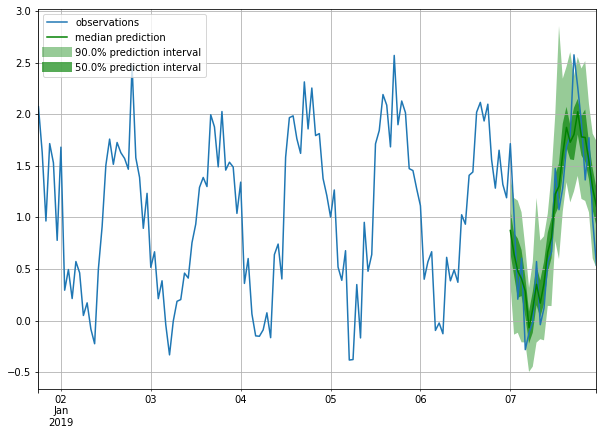

In [66]:
plot_prob_forecasts(ts_entry, forecast_entry)

### Compute metrics

In [ ]:
'''
我们也可以用数字来评估预测的质量。在GluonTS中，Evaluator类可以计算聚合性能度量(跨时间步和跨时间序列进行聚合)，以及每个时间序列的度量(跨时间步聚合)(这对于分析跨异质时间序列性能非常有用)
'''

In [67]:
from gluonts.evaluation import Evaluator

In [68]:
evaluator = Evaluator(quantiles=[0.1, 0.5, 0.9])
agg_metrics, item_metrics = evaluator(iter(tss), iter(forecasts), num_series=len(test_ds))

Running evaluation: 100%|██████████| 100/100 [00:00<00:00, 188.09it/s]


In [69]:
print(json.dumps(agg_metrics, indent=4))

{
    "MSE": 0.11689357300599415,
    "abs_error": 652.0211997032166,
    "abs_target_sum": 2505.765546798706,
    "abs_target_mean": 1.044068977832794,
    "seasonal_error": 0.3378558193842571,
    "MASE": 0.8110764845918209,
    "MAPE": 3.375893298492565,
    "sMAPE": 0.5202943392712507,
    "OWA": NaN,
    "MSIS": 5.635922356723241,
    "QuantileLoss[0.1]": 288.99942701244726,
    "Coverage[0.1]": 0.11666666666666668,
    "QuantileLoss[0.5]": 652.0211960636079,
    "Coverage[0.5]": 0.5545833333333333,
    "QuantileLoss[0.9]": 305.4979713857174,
    "Coverage[0.9]": 0.9070833333333332,
    "RMSE": 0.3418970210545774,
    "NRMSE": 0.327465932149678,
    "ND": 0.26020838243874017,
    "wQuantileLoss[0.1]": 0.11533378586901899,
    "wQuantileLoss[0.5]": 0.2602083809862465,
    "wQuantileLoss[0.9]": 0.12191801893677276,
    "mean_absolute_QuantileLoss": 415.50619815392423,
    "mean_wQuantileLoss": 0.1658200619306794,
    "MAE_Coverage": 0.02611111111111107
}


In [70]:
item_metrics.head()

,item_id,MSE,abs_error,abs_target_sum,abs_target_mean,seasonal_error,MASE,MAPE,sMAPE,OWA,MSIS,QuantileLoss[0.1],Coverage[0.1],QuantileLoss[0.5],Coverage[0.5],QuantileLoss[0.9],Coverage[0.9]
0,NaN,0.130021,7.043859,24.638548,1.026606,0.351642,0.834640,0.961615,0.552452,NaN,6.782110,2.508494,0.083333,7.043859,0.583333,3.760771,0.916667
1,NaN,0.118082,6.200833,22.178631,0.924110,0.340241,0.759367,2.178547,0.587683,NaN,5.766933,2.675089,0.083333,6.200833,0.750000,3.058608,0.916667
2,NaN,0.126092,6.321709,26.601139,1.108381,0.323560,0.814083,0.338865,0.387058,NaN,6.787340,3.120924,0.083333,6.321709,0.458333,3.126291,0.916667
3,NaN,0.125740,6.234529,22.502333,0.937597,0.311026,0.835210,0.916487,0.484880,NaN,7.236085,3.308530,0.208333,6.234529,0.583333,3.390347,0.958333
4,NaN,0.083647,4.866461,25.864388,1.077683,0.313119,0.647578,1.320937,0.477489,NaN,6.364174,2.354547,0.041667,4.866461,0.541667,2.946431,0.916667


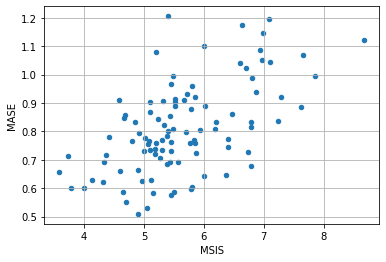

In [71]:
item_metrics.plot(x='MSIS', y='MASE', kind='scatter')
plt.grid(which="both")
plt.show()

## Create your own model

In [ ]:
'''
创建自己的预测模型需要：
    1、定义训练和预测网络
    2、定义新的estimator，指定任何数据处理并使用网络
训练和预测网络可以任意复杂，但应该遵循一些基本法则：
    1、两者都应该具有hybrid_forward方法，定义调用网络时应执行的操作
    2、训练网络的hybrid_forward方法应返回一个基于预测和真值的loss
    3、预测网络的hybrid_forward方法应返回预测
estimator应遵循以下法则：
    1、它应该包括一个create_transformation方法，该方法定义了所有可能的特征转换以及在训练期间如何分割数据
    2、它应该包括一个create_training_network方法，该方法返回配置了任何必要超参数的训练网络
    3、它应该包括一个create_predictor方法，该方法创建预测网络并返回一个Predictor对象
一个Predictor定义给定predictor的predictor.predict方法，该方法输入测试数据集，通过预测网络进行预测，得到预测结果。可以将Predictor对象视为定义其predict方法的预测网络的包装器wrapper
'''

In [ ]:
'''
我们将从创建一个仅限于点预测的前馈网络开始。然后，我们将其扩展到概率预测，考虑时间序列的特征和伸缩性scaling，从而增加网络的复杂性，最后我们将其替换为RNN。我们需要强调的是，以下模型的实现方式和所做的所有设计选择既不具有约束力，也不一定是最优的。它们的唯一目的是提供关于如何构建模型的指导和提示
'''

### Point forecasts with a simple feedforward network

In [ ]:
'''
我们可以创建一个简单的训练网络，该网络定义一个神经网络，该神经网络以长度为上下文长度的窗口作为输入，并预测随后的维数为预测长度的窗口(因此，网络的输出维数为预测长度)。训练网络的hybrid_forward方法返回L1损失的平均值。预测网络应该与训练网络相同(通过继承类)，并且它的hybrid_forward方法返回预测
'''